In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python310.zip', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/lib-dynload', '', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [2]:
from bioomics import QueryComplex, DistanceAnalyze, DistanceProcess
from layout import Layout
from plot_interface import PlotInterface
from load_data import LoadData

In [3]:
# antibody
adf = LoadData.antibody()
adf.head()

INFO:mysql.connector:package: mysql.connector.plugins
INFO:mysql.connector:plugin_name: caching_sha2_password
INFO:mysql.connector:AUTHENTICATION_PLUGIN_CLASS: MySQLCachingSHA2PasswordAuthPlugin


pdb 8737
chains 29089


,allele_name,specie,gene_name,gene_family,chain_type,pdb_id,chain_id,model_no,chain_no,pro_id,chain_seq,pro_len,release_date,structure_method,resolution,avg_bfactor,relative_faa,chain_pdb,pdb_group
0,IGKV8-21*01,Mus_musculus,IGKV8-21,IGKV8,K,3IJH,3IJH_0_A_0,0,A,143006,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,217,2009-10-06,x-ray diffraction,2.10,27.2235,meta_chain_faa/3I/3IJH/3IJH_0_A_0.faa,meta_chain_pdb/3I/3IJH/3IJH_0_A_0.pdb,0.0
1,IGHV7-3*02,Mus_musculus,IGHV7-3,IGHV7,H,3IJH,3IJH_0_B_0,0,B,148148,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,221,2009-10-06,x-ray diffraction,2.10,29.0730,meta_chain_faa/3I/3IJH/3IJH_0_B_0.faa,meta_chain_pdb/3I/3IJH/3IJH_0_B_0.pdb,0.0
2,IGKV8-21*01,Mus_musculus,IGKV8-21,IGKV8,K,3IJH,3IJH_0_C_0,0,C,143006,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,217,2009-10-06,x-ray diffraction,2.10,34.2494,meta_chain_faa/3I/3IJH/3IJH_0_C_0.faa,meta_chain_pdb/3I/3IJH/3IJH_0_C_0.pdb,0.0
3,IGHV7-3*02,Mus_musculus,IGHV7-3,IGHV7,H,3IJH,3IJH_0_D_0,0,D,148148,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,221,2009-10-06,x-ray diffraction,2.10,30.9271,meta_chain_faa/3I/3IJH/3IJH_0_D_0.faa,meta_chain_pdb/3I/3IJH/3IJH_0_D_0.pdb,0.0
4,IGKV1-21*01,Macaca_mulatta,IGKV1-21,IGKV1,K,9IJS,9IJS_0_H_0,0,H,152834,VQLVESGGGLVQPGGSLRLSCAASGFNVYSSSIHWVRQAPGKGLEW...,225,2025-09-03,electron microscopy,3.64,119.2310,meta_chain_faa/9I/9IJS/9IJS_0_H_0.faa,meta_chain_pdb/9I/9IJS/9IJS_0_H_0.pdb,0.0


In [4]:
# IMGT regions
vregion, vg = LoadData.imgt_regions()
vg[('3IJH', 'A', 'CDR1')]

pdb 8737
chains 29089


,pdb_id,chain_id,chain_no,region_name,seq_from,seq_to,seq,seq_len
0,3IJH,3IJH_0_A_0,A,CDR1,26,37,QSLLNSRTRKNY,12


In [5]:
# retrieve interface sequences
table_name = 'pdb_distance'
cutoff = 10
span =5
file_name = f"{table_name}_cutoff{cutoff}_span{span}"
infile = f'/home/yuan/output/pdb/collect/distance/{file_name}.csv'
motifs = pd.read_csv(infile)
print(len(motifs))
motifs.head()

443821


,seq,pair_aa,sig_res,start,end,dist_cutoff,max_span,chain_no,pair_chain_no,pdb_id,combo_id
0,QIVLTQSPAI,KGKLQGGIII,7,0,9,10.0,5,C,D,3J2Y,3J2Y_0_C-D
1,TYMYWYQQKPGSSPRLLIYDTSNLASGV,GGYYFFDLDPYYGWDDDFYYYYYYDDDD,27,29,56,10.0,5,C,D,3J2Y,3J2Y_0_C-D
2,TYYCQQRTNYPLTFGAGTK,LLLLFGGGGHNGLFGGGGI,19,83,101,10.0,5,C,D,3J2Y,3J2Y_0_C-D
3,TVSIFPPSSEQLTSGGASVVCFLNNFYPK,TTTVAARPRKKRYYKKKKLLFFFFHFHFF,27,112,140,10.0,5,C,D,3J2Y,3J2Y_0_C-D
4,NGVLNSWTDQDSKDSTYSMSSTLTLTKDEY,QQLLLFFFHHHHGHHHFFFFSKKKKKKKKK,27,155,184,10.0,5,C,D,3J2Y,3J2Y_0_C-D


## parse FR

FR1 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='FR1'>

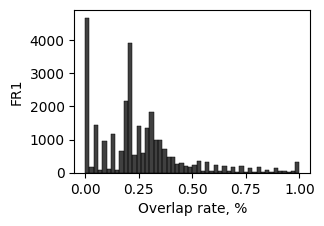

In [7]:
region_name = 'FR1'

cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

FR1 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='FR1'>

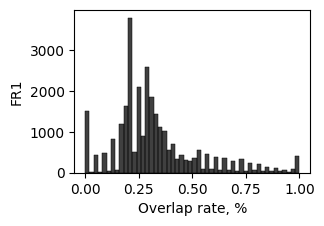

In [8]:
region_name = 'FR1'

cdr = LoadData.scan_regions(region_name, motifs, vg, offset=5)
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

FR2 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='FR2'>

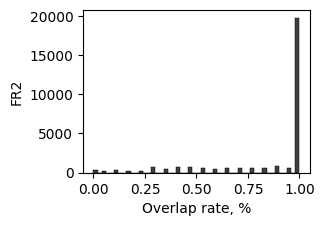

In [9]:
region_name = 'FR2'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

FR3 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='FR3'>

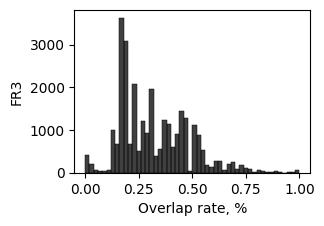

In [10]:
region_name = 'FR3'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

FR3 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='FR3'>

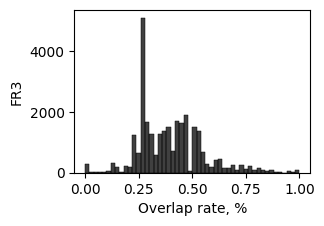

In [11]:
region_name = 'FR3'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=5)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

## parse CDR

CDR1 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='CDR1'>

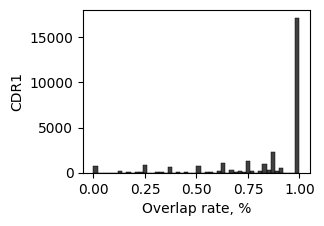

In [12]:
region_name = 'CDR1'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

CDR2 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='CDR2'>

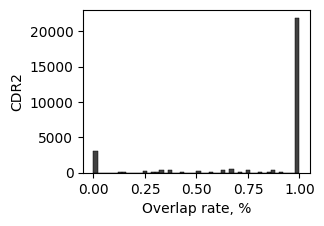

In [13]:
region_name = 'CDR2'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

CDR3 28815
figure size: 8.5 x 6 cm


<Axes: xlabel='Overlap rate, %', ylabel='CDR3'>

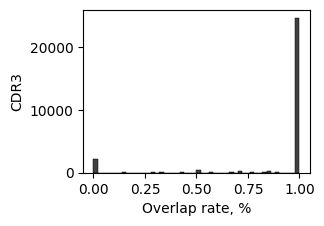

In [14]:
region_name = 'CDR3'
cdr = LoadData.scan_regions(region_name, motifs, vg, offset=1)

args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()
PlotInterface(cdr).hist_overlap(ax, region_name)

## figures

In [15]:
region_names = ['CDR1','CDR2','CDR3',]
overlaps_cdr = {}
for region_name in region_names:
    overlaps_cdr[region_name] = LoadData.scan_regions(region_name, motifs, vg, offset=1)

CDR1 28815
CDR2 28815
CDR3 28815


figure size: 17.4 x 5 cm


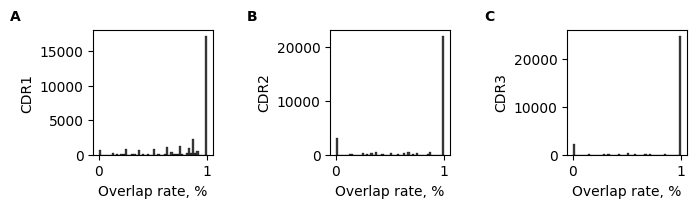

In [16]:
args = {'width_level':3, 'height':5, 'space':.15}
label_x = (-60, -60, -60)
label_y = 15
fig, axes = Layout(args).row(label_x, label_y)

for i, region_name in enumerate(region_names):
    PlotInterface(overlaps_cdr[region_name]).hist_overlap(axes[i], region_name)

fig.savefig(f'../figures/parseCDR_{file_name}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

In [17]:
region_names = ['FR1','FR2','FR3',]
overlaps_fr = {}
for region_name in region_names:
    overlaps_fr[region_name] = LoadData.scan_regions(region_name, motifs, vg, offset=1)

FR1 28815
FR2 28815
FR3 28815


figure size: 17.4 x 5 cm


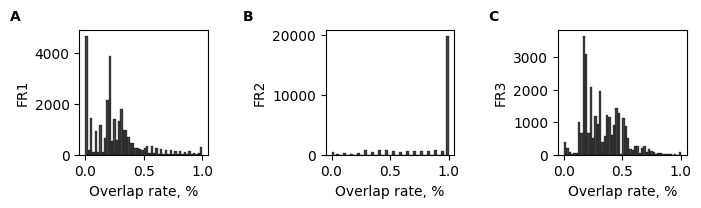

In [19]:
args = {'width_level':3, 'height':5, 'space':.15}
label_x = (-50, -60, -50)
label_y = 15
fig, axes = Layout(args).row(label_x, label_y)

for i, region_name in enumerate(region_names):
    PlotInterface(overlaps_fr[region_name]).hist_overlap(axes[i], region_name)

fig.savefig(f'../figures/parseFR_{file_name}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

In [ ]:
data_dir = '/home/yuan/output/pdb'
relative_pfile = 'meta_pdb_distance/2U/2UUN/2UUN_0_D-P.pkl'
args = {
    'pickle_file': os.path.join(data_dir, relative_pfile),
    'max_span': 3,
    'dist_cutoff': 5,
}
da = DistanceAnalyze(args)
da.data

In [ ]:
data_dir = '/home/yuan/output/pdb'
relative_pfile = 'meta_pdb_distance/3I/3IJJ/3IJJ_0_A-B.pkl'
args = {
    'pickle_file': os.path.join(data_dir, relative_pfile),
    'max_span': 3,
    'dist_cutoff': 5,
}
da = DistanceAnalyze(args)

res = da.retrieve_motif(min_seq_len=6)
res[0]